<img src='static/spark.png' width="30%" height="30%" />


# Distributed operations with RDDs

### Trnasformations and actions
___
In RDD's there are two basic classes of distributed unary operations, transformations and actions. The transformations are distributed operations whose result generates a new RDD from another, while the actions, is a type of operation that applies a function of aggregation in a systematic and recurrent way to all the RDD.


The transformations are operations lazy evaluated, that is to say that Spark does not execute the transformations of immediate way, if not until one an action (evaluation) at the end of a sequence of transformations fires them, while that event happens internally Spark generates a series Of operations pointing to the cluster indicating that the driver has associated a sequence of calculation requests, leaving the state of the driver latent to be processed.

**Example**

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
numbersStrRDD = sc.textFile('data/amounts.txt')

In [3]:
numbersStrRDD.take(5)

['594.38', '281.37', '144.85', '20.99', '797.40']

### Map and Reduce
---

Maps is a type of **transformation** which create a new dataset from an existing one through a **map one to one**.

#### Note: Lambda Operator

In python and scala the operations map, reduce and filters are applied by lambda expresions througt the lambda operator. The lambda operator or lambda function is a way to create small anonymous functions. These functions are throw-away functions, i.e. they are just needed where they have been created. Lambda functions are mainly used in combination with the functions filter(), map() and reduce(). The lambda feature was added to Python due to the demand from Lisp programmers.

The general syntax of a lambda function is quite simple:

**lambda** argument_list: **expression**.

More info abouth lambda operator: [http://www.python-course.eu/lambda.php]

**Maps**

A map its a one to one function $\lambda(x)$ such that preserves the size of the rdd and preserve the partitions.

** Example:** Map Example


<img src='static/mapconcept.png' width="55%" height="55%"/>


In [4]:
# Casting the elements of the RDD into a distributes way
floatsRDD = numbersStrRDD.map(lambda x: float(x))
floatsRDD.take(5)

[594.38, 281.37, 144.85, 20.99, 797.4]

In [5]:
def f(x): return x+1
floatsRDD.map(lambda x: f(x)).take(5)

[595.38, 282.37, 145.85, 21.99, 798.4]

** Example: Filter example:**

The next operations aply a change of type from string to float for each entry of the rdd

In [6]:
filterLimit = 50
floatsRDD.filter(lambda x: x<=filterLimit).count()

478

**Actions**, are operations which return a value to the driver program after running a computation on the dataset, **actions reduce all records** applying a *function to two or more entries*.

Some **Actions** and **Transfomations**:

<br>
<div align="center">
     <img src="static/RddOperations.png" width="40%">
</div>

**Reductions**

If $x,y$ are elements of the same type then a reduction $\lambda(x,y)$ its a function that must satisfy:

* Closed: $\lambda$ must return another object of the same class $type(\lambda(x,y))=type(x)=type(y)$
* Asociative: $\lambda(\lambda(x,y),z)=\lambda(x,\lambda(y,z))$
* Conmutative: $\lambda(x,y)=\lambda(y,x)$

** Example:** Reduce example

The next operations apply a reduce that take two entries of the RDD and apply a sum them recursively since the sum of numbers satisfy the three conditions. 

<img src='static/reductionConcept.png' width="45%" height="45%" />

The conceptual way to compute a distributed count using a mapd following by the last reduction.

<img src='static/countDistirbuted.png' width="60%" height="60%" />


In [7]:
import math as mt

theSumOfTheRDD = floatsRDD.reduce(lambda x,y: x+y)
theCountOfTheRDD = floatsRDD.map(lambda x: 1).reduce(lambda x,y: x+y)
mean = theSumOfTheRDD/theCountOfTheRDD
sse = floatsRDD.map(lambda x: (x-mean)**2).reduce(lambda x,y: x+y)
stDev = mt.sqrt(sse/(theCountOfTheRDD-1))

print("The sum of the entire rdd: "+str(theSumOfTheRDD))
print("The count of the entire rdd: "+str(theCountOfTheRDD))
print("The average is: "+str(mean))
print("The standar deviation is: "+str(stDev))

The sum of the entire rdd: 2478099.1799999997
The count of the entire rdd: 5000
The average is: 495.61983599999996
The standar deviation is: 499.7599287420799


Note that the count and the sum computing are indepents one each other, in other words it's possible describe de dependence of this tasks through a driagram of dependencies called **Directed Acyclic Graph (DAG)**.

<br>
<div align="center">
     <img src="static/dag1.png" width="25%">
</div>

**Example** Distributed max and min:

In [8]:
# Defining some functions:
def Max(x,y):
    if(x<=y):
        return y
    else:
        return x
def Min(x,y):
    if(x<=y):
        return x
    else:
        return y

myMax = floatsRDD.reduce(lambda x,y: Max(x,y))
myMin = floatsRDD.reduce(lambda x,y: Min(x,y))

print('Max: '+str(myMax)+' Min: '+str(myMin))

Max: 4561.86 Min: 0.06


### Excercises

* Compute the harmonic mean and the geometric men for the rdd of amounts.

* Generate the rdds performing the folllowing normalizations over the rdd of amounts:

$$standarization(x) = \frac{x - \bar{x}}{s}$$

$$scaling(x) = \frac{x - \bar{min}}{max - min}$$

### FlatMap and reduce by key

---

**FlatMap:** Map and flatMap are similar, in the sense they take a line from the input RDD and apply a function on it. The way they differ is that the function in map returns only one element, while function in flatMap can return a list of elements (0 or more) as an iterator. Also, the output of the flatMap is flattened. Although the function in flatMap returns a list of elements, the flatMap returns an RDD which has all the elements from the list in a flat way.

**Example** Spliting words:

<br>
<div align="center">
     <img src="static/flatmap.png" width="45%">
</div>

In [9]:
versesRDD = sc.textFile('data/green_eggs_and_ham.txt')
versesRDD.take(2)

['I AM SAM  I AM SAM  SAM I AM',
 'THAT SAM I AM  THAT SAM I AM  I DO NOT LIKE THAT SAM I AM']

In [10]:
wordsRDD = versesRDD.flatMap(lambda verse: verse.split(' '))
wordsRDD.take(5)

['I', 'AM', 'SAM', '', 'I']

**Reduction By Key:** Is one step ahead then reduce function in Spark with the contradiction that it is a transformation operation, this operation that works only for RDDs which contains key and value pairs kind of elements (i.e RDDs having tuple or Map as a data element). It is a transformation operation which means it is lazily evaluated. We need to pass one associative function as a parameter, which will be applied to the source RDD and will create a new RDD as with resulting values(i.e. key value pair). This operation is a wide operation as data shuffling may happen across the partitions.

**Example: ** Word Count

<br>
<div align="center">
     <img src="static/reducebykey.png" width="60%">
</div>


In [11]:
countsRDD = wordsRDD.filter(lambda w: w!= '').map(lambda w: (w,1)).reduceByKey(lambda x,y: x+y)
countsRDD.take(15)

[('SAM', 18),
 ('THAT', 3),
 ('LIKE', 44),
 ('YOU', 34),
 ('GREEN', 10),
 ('EGGS', 11),
 ('THEM', 58),
 ('ANYWHERE', 8),
 ('THEN', 1),
 ('EAT', 23),
 ('COULD', 14),
 ('CAR', 7),
 ('THEY', 2),
 ('ARE', 2),
 ('MAY', 4)]

**Example**: Calculating Probability - Dice problem


Lets supose that we have two dices with equal probability, each face of a die is marked with a different number from 1 to 6, so the two dice are rolled and the outcome of the first and secondone dice are sumed, How many possible outcomes can occur in this game, what is the probability of each of them?, If the dice have k faces?.

First it's necesary to draw and list possible outcomes for the two dices:

<br>
<div align="center">
     <img src="static/dices1.gif" width="45%">
</div>

Since the two dice have same probability for each outcome, its possible group all the outcomes that have the same sum, and then count number cases for each outcome divided by the total of cases:

<br>
<div align="center">
     <img src="static/distributionSum.png" width="50%">
</div>

In cooding for k faces:

In [12]:
import numpy as np

def combineFace(face,k):
    rolls = []
    for i in np.arange(1,k+1):
        rolls.append((face+i,face,i))
    return rolls

combineFace(1,6)

[(2, 1, 1), (3, 1, 2), (4, 1, 3), (5, 1, 4), (6, 1, 5), (7, 1, 6)]

In [13]:
k = 6
sc.broadcast(k)

facesRDD = sc.parallelize(np.arange(1,k+1)).flatMap(lambda x: combineFace(x,k))
totalOutcomes = facesRDD.count()
sc.broadcast(totalOutcomes)

#print('faces: '+str(facesRDD.map(lambda x:(x[1],x[2])).collect()))

probilityRDD = facesRDD.map(lambda x: (x[0],1))\
                       .reduceByKey(lambda x,y: x+y)\
                       .map(lambda x: (x[0],x[1]/totalOutcomes))

probilityRDD.collect()

[(8, 0.1388888888888889),
 (9, 0.1111111111111111),
 (2, 0.027777777777777776),
 (10, 0.08333333333333333),
 (3, 0.05555555555555555),
 (11, 0.05555555555555555),
 (4, 0.08333333333333333),
 (12, 0.027777777777777776),
 (5, 0.1111111111111111),
 (6, 0.1388888888888889),
 (7, 0.16666666666666666)]

In [14]:
import matplotlib.pyplot as plt

plt.hist(facesRDD.map(lambda x: x[0]).collect(),bins=11)
plt.show()

**Example**: Simulating the sum of two dices

In [15]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt

def rollDice(k):
    u = np.random.uniform(0,1)
    print(u)
    return mt.floor(u*k)+1

In [27]:
parts = 10
rolls = 2000

sc.broadcast(rolls)

rollsRDD = sc.parallelize(np.arange(1,parts))\
                            .flatMap(lambda x: [1]*rolls)\
                            .map(lambda x: (rollDice(k)+rollDice(k),x))
        
totalRolls = rollsRDD.count()
sc.broadcast(totalRolls)

frequencyRolls = rollsRDD.reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],x[1]/totalRolls))
frequencyRolls.collect()

[(8, 0.13933333333333334),
 (9, 0.11027777777777778),
 (10, 0.08394444444444445),
 (2, 0.02711111111111111),
 (3, 0.054),
 (11, 0.05488888888888889),
 (4, 0.08377777777777778),
 (12, 0.026111111111111113),
 (5, 0.10955555555555556),
 (6, 0.14483333333333334),
 (7, 0.16616666666666666)]

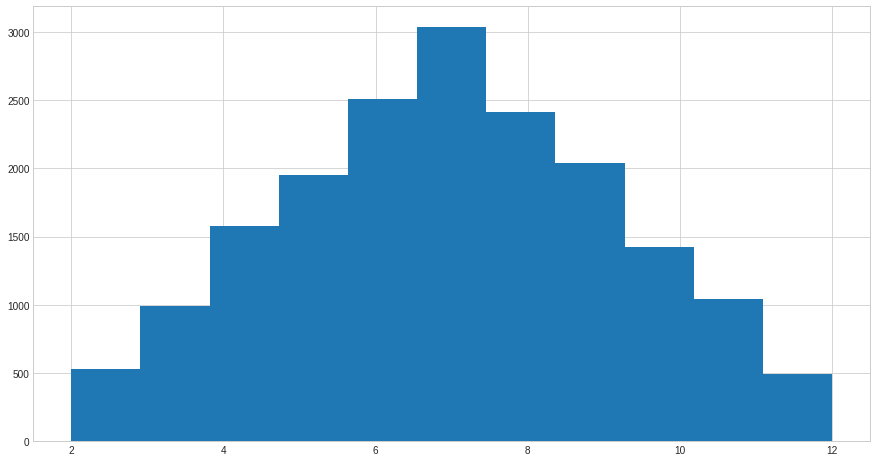

In [28]:
plt.figure(figsize=(15,8))
plt.hist(rollsRDD.map(lambda x: x[0]).collect(),bins=11,alpha=1)
plt.show()

**Example**: Galtons Board

Consider the vertical board shown below, where 5 rows of nails have been placed in a triangular shape. A ball dropped from the top collides with the first nail and falls to the lower left nail with probability p or lower to the right lower nail with probability 1-p, and so on until it falls into one of the 6 ballot boxes that are at the bottom.

<br>
<div align="center">
     <img src="static/GaltonBoard.png" width="40%">
</div>

Make a program in spark that simulates this process with a big number of balls and plot the histogram, consider the number boxes variable.

<br>
<div align="center">
     <img src="static/galtonSim.gif" width="50%">
</div>



In [18]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
def bernoulliExp(p): return 1 if(np.random.uniform(0,1) <= p) else 0
def binomialExp(n,p): return sum([bernoulliExp(p) for i in range(0,n)])

In [19]:
slots = 30
p = 0.5
experimentsPertPartition = 2000 
partitions = 5
experimentsRDD = sc.parallelize(np.arange(1,slots+1),partitions)\
                   .flatMap(lambda x: [binomialExp(slots,p) for i in range(0,experimentsPertPartition)])
countExperimentsRDD = experimentsRDD.map(lambda x: (x,1))\
                                    .reduceByKey(lambda x,y: x+y)\
                                    .map(lambda x: (x[0],x[1]/(slots*experimentsPertPartition)))
countExperimentsRDD.collect()

[(15, 0.14178333333333334),
 (10, 0.02785),
 (20, 0.028383333333333333),
 (5, 0.0004),
 (25, 0.00035),
 (16, 0.1352),
 (11, 0.05125),
 (21, 0.01375),
 (6, 0.0005833333333333334),
 (26, 1.6666666666666667e-05),
 (17, 0.11061666666666667),
 (12, 0.08321666666666666),
 (7, 0.0013333333333333333),
 (22, 0.00515),
 (13, 0.10911666666666667),
 (18, 0.0828),
 (23, 0.0017166666666666667),
 (8, 0.004883333333333333),
 (3, 6.666666666666667e-05),
 (19, 0.05503333333333333),
 (14, 0.13311666666666666),
 (9, 0.01255),
 (24, 0.0008333333333333334)]

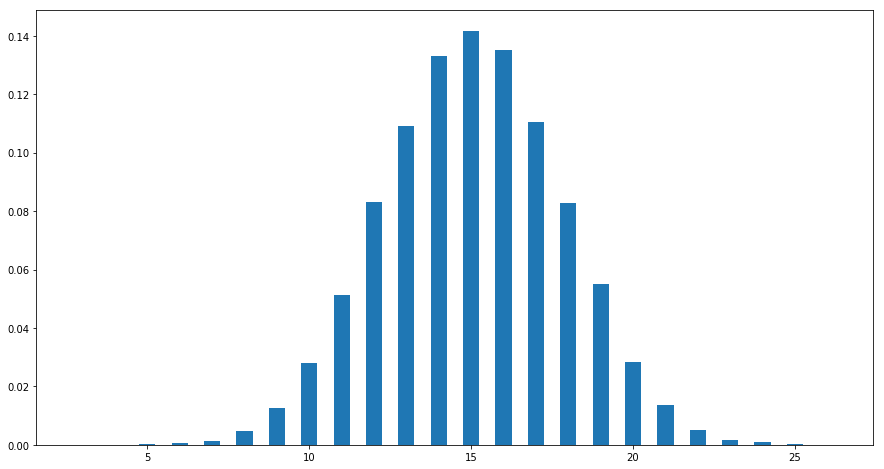

In [20]:
x = [t[0] for t in countExperimentsRDD.collect()]
y = [t[1] for t in countExperimentsRDD.collect()]
plt.figure(figsize=(15,8))
plt.bar(x,y,0.5)
plt.show()

**Example: Descriptive statistics - Computing a distirbuted histogram**

In [21]:
def intervalClass(value):
    interval = math.floor((value-minimum)/intervalLength)
    if (interval >= bins):
        return bins-1
    else:
        return interval

In [22]:
import math
bins = 15
maximum = floatsRDD.max()
minimum = floatsRDD.min()
intervalLength = (maximum-minimum)/bins
frequencyTableRDD = floatsRDD.map(lambda x:(intervalClass(x),1))\
                             .reduceByKey(lambda x,y: x+y)\
                             .map(lambda y:(y[0]+1,\
                                  minimum+intervalLength*y[0],\
                                  minimum+intervalLength*(y[0]+1),\
                                  y[1]/theCountOfTheRDD))
frequencyTableRDD.collect()

[(1, 0.06, 304.17999999999995, 0.4616),
 (3, 608.2999999999998, 912.4199999999998, 0.128),
 (5, 1216.5399999999997, 1520.6599999999996, 0.0398),
 (7, 1824.7799999999997, 2128.8999999999996, 0.0104),
 (11, 3041.2599999999993, 3345.379999999999, 0.0008),
 (9, 2433.0199999999995, 2737.1399999999994, 0.003),
 (15, 4257.74, 4561.86, 0.0006),
 (13, 3649.4999999999995, 3953.6199999999994, 0.0004),
 (2, 304.17999999999995, 608.2999999999998, 0.2504),
 (4, 912.4199999999998, 1216.5399999999997, 0.069),
 (8, 2128.8999999999996, 2433.0199999999995, 0.0072),
 (6, 1520.6599999999996, 1824.7799999999997, 0.0268),
 (12, 3345.379999999999, 3649.4999999999995, 0.0002),
 (10, 2737.1399999999994, 3041.2599999999993, 0.0018)]

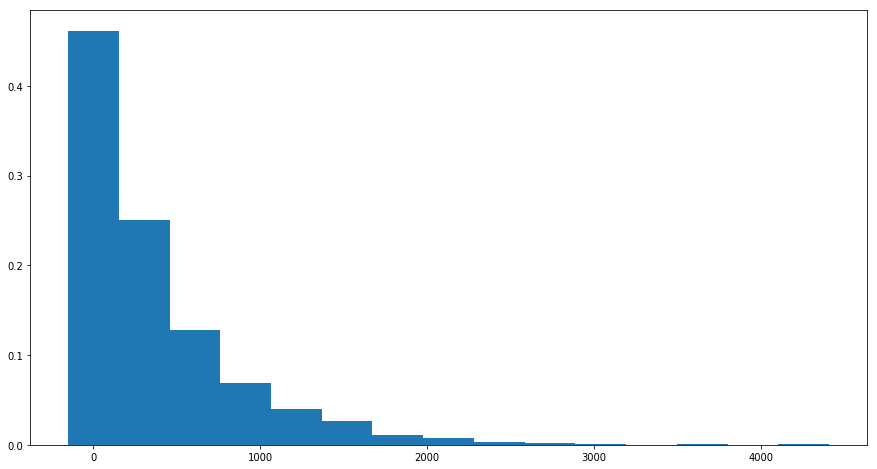

In [23]:
import numpy as np
import matplotlib.pyplot as plt
x = frequencyTableRDD.map(lambda x: x[1]).collect()
y = frequencyTableRDD.map(lambda x: x[3]).collect()
plt.figure(figsize=(15,8))
plt.bar(x,y,intervalLength)
plt.show()

Finding the curve that generates that patern

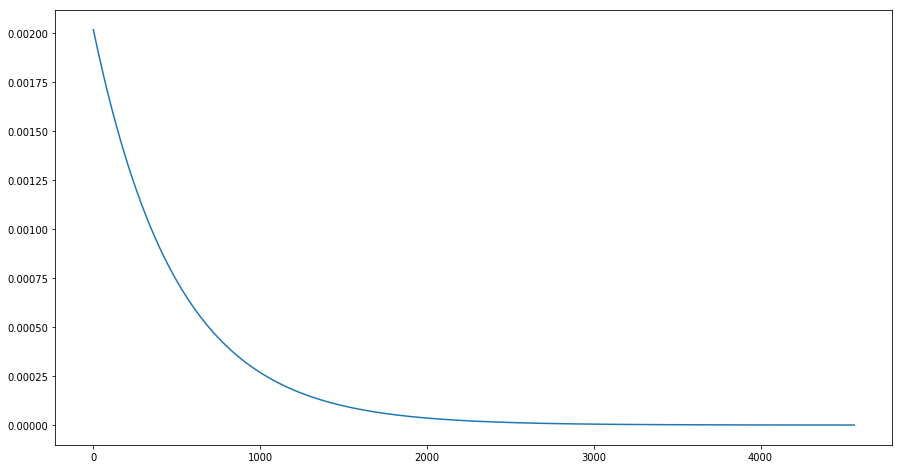

In [24]:
from scipy.stats import expon
estimator = floatsRDD.mean()

plt.figure(figsize=(15,8))
x_t = np.linspace(0,maximum,5000)
plt.plot(x_t,expon.pdf(x_t,loc=0,scale=estimator))

**Generating fake data**

1. Lets take the last curve equation:
$$f_X(x)=\frac{1}{\lambda}e^{\left[\frac{-x}{\lambda}\right]}$$

2. Integrate the curve from 0 to x:
$$F_X(x)=\int_{0}^{x}  \frac{1}{\lambda}e^{\left[\frac{-x}{\lambda}\right]}dx=1-e^{\left[\frac{-x}{\lambda}\right]}$$

3. Equate to a number $q$, and invert the function in order to put the $x$ as function of $q$.
$$x(q) = -\lambda Log(1-q)$$

3. Compute the parameter $\lambda$ as the mean of your data and generate a random number $q_0 \in [0,1]$ and evaluate the function with $q_0$ given a fixed $\hat{\lambda}$.
$$x = -\hat{\lambda} Log(1-q_0)$$

4. Your fake x was generated, repeat the process n times, as n get bigger its better.


In [25]:
dataLength = theCountOfTheRDD

def quantileFunction(quantile,lambdaRate):
    return -1*np.log(1-quantile)*lambdaRate

simulatedAmountsRDD = sc.parallelize(dataLength*[1])\
                        .map(lambda x: np.random.uniform(0,1))\
                        .map(lambda x: quantileFunction(x,estimator))

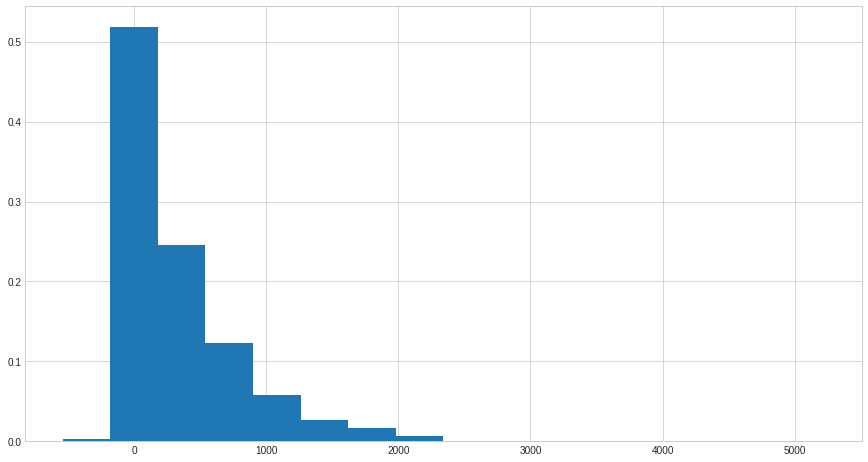

In [26]:
bins = 15
maximum = simulatedAmountsRDD.max()
minimum = simulatedAmountsRDD.min()
intervalLength = (maximum-minimum)/bins
simulatedfrequencyTableRDD =  simulatedAmountsRDD.map(lambda x:(intervalClass(x),1))\
                                                 .reduceByKey(lambda x,y: x+y)\
                                                 .map(lambda y:(y[0]+1,\
                                                      minimum+intervalLength*y[0],\
                                                      minimum+intervalLength*(y[0]+1),\
                                                      y[1]/theCountOfTheRDD))
x_s = simulatedfrequencyTableRDD.map(lambda x: x[1]).collect()
y_s = simulatedfrequencyTableRDD.map(lambda x: x[3]).collect()
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,8))
plt.bar(x_s,y_s,intervalLength)
plt.show()

### Excercises

* Use the file **green_eggs_and_ham.txt** and obtain an rdd that contains the frequency table for the distribution of word lenghts. 

* For the rdds that contains the scaled and normalized values of amounts compute the histogram with 10 bins and plot the distirbutions.

* Compute the cumulative distribution for the histogram of amounts and normalized amounts and plot the histogram.

* Lets supose that we have two dices with equal probability, each face of a die is marked with a different number from 1 to 6, then just we choose the face with the largest number, How many possible outcomes can occur in this game, what is the probability of each of them?, If the dice have k sides?.

<br>
<div align="center">
     <img src="static/dices2.png" width="28%">
</div>

* Compute mean, variance, cumulative probability for the distributions of word lenghts, sum dices and max of twoo dices using the following formulas.

$$\bar{x}=\sum_{x} (x) frequency(x) \\  s^2 = \sum_{x} (x-\bar{x})^2 frequency(x)  $$


* Simulate this random variable and given a "big number" in order to aproximate the actual probabilities. 